In [1]:
import os

PATH = '/home/stadlerm/Development/Projects/DreamChallenge/RA2_alpine_lads'

os.chdir(PATH)

In [2]:
from utils.config import Config

config = Config()

In [3]:
from dataset.joint_dataset import feet_joint_dataset

feet_joint_erosion_dataset, val_dataset = feet_joint_dataset(config).create_feet_joints_dataset(True, val_split = True)

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K

# source: https://github.com/umbertogriffo/focal-loss-keras/blob/master/losses.py

def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(128, 256 ,1)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation = 'softmax')
])

In [6]:
model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer='adam')

In [7]:
history = model.fit(
    feet_joint_erosion_dataset, epochs = 5, steps_per_epoch = 25, validation_data = val_dataset, validation_steps = 2
)

Train for 25 steps, validate for 2 steps
Epoch 1/5
25/25 [==============================] - 19s 775ms/step - loss: 0.0999 - accuracy: 0.8224 - val_loss: 0.0699 - val_accuracy: 0.9000
Epoch 2/5
25/25 [==============================] - 13s 503ms/step - loss: 0.0395 - accuracy: 0.9488 - val_loss: 0.0525 - val_accuracy: 0.9200
Epoch 3/5
25/25 [==============================] - 13s 524ms/step - loss: 0.0584 - accuracy: 0.8960 - val_loss: 0.0602 - val_accuracy: 0.9000
Epoch 4/5
25/25 [==============================] - 13s 522ms/step - loss: 0.0707 - accuracy: 0.8640 - val_loss: 0.0490 - val_accuracy: 0.9000
Epoch 5/5
25/25 [==============================] - 13s 533ms/step - loss: 0.0402 - accuracy: 0.9344 - val_loss: 0.0690 - val_accuracy: 0.8800


tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float64)


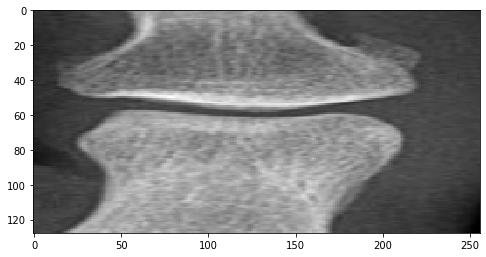

In [9]:
import matplotlib.pyplot as plt

for x, y in feet_joint_erosion_dataset.take(1):
    print(y[0])
    
    plt.figure(figsize = (8, 8))
    plt.imshow(x[0, :, :, 0], cmap="gray")
    plt.show()